## Exploratory Data Analysis (EDA)
let explore the data to see trends

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from numpy import median

In [2]:
# import data
df =pd.read_csv('\\Users\\cofos\\Downloads\\lisitngs.csv')

#define the columns we want to keep

columns_to_included = ['last_scraped','host_since', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'square_feet', 'price', 'cleaning_fee','number_of_reviews',
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'cancellation_policy','require_guest_profile_picture',]

# Select the columns we need for the analysis

df= df[columns_to_included]
df.head()

,last_scraped,host_since,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,price,cleaning_fee,number_of_reviews,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture
0,1/4/2016,8/11/2011,t,Queen Anne,47.636289,-122.371025,Apartment,Entire home/apt,4,1.0,...,$85.00,NaN,207,NaN,$5.00,2,1,f,moderate,f
1,1/4/2016,2/21/2013,t,Queen Anne,47.639123,-122.365667,Apartment,Entire home/apt,4,1.0,...,$150.00,$40.00,43,$100.00,$0.00,1,2,f,strict,t
2,1/4/2016,6/12/2014,t,Queen Anne,47.629724,-122.369483,House,Entire home/apt,11,4.5,...,$975.00,$300.00,20,"$1,000.00",$25.00,10,4,f,strict,f
3,1/4/2016,11/6/2013,t,Queen Anne,47.638473,-122.369279,Apartment,Entire home/apt,3,1.0,...,$100.00,NaN,0,NaN,$0.00,1,1,f,flexible,f
4,1/4/2016,11/29/2011,t,Queen Anne,47.632918,-122.372471,House,Entire home/apt,6,2.0,...,$450.00,$125.00,38,$700.00,$15.00,6,1,f,strict,f


In [3]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - pandas dataframe
    This function cleans df using the following steps:
    1. The price column has certain characters such as $ and comma that need to be remove and convert them to float.
    2. Filling missing values with mode for the categorical variables and 0.00 for price columns.
    3. Change columns with dtype object to category.
    '''
#The price column has certain characters such as $ and comma that need to be remove and convert them to float
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
    df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype(float)
    df['extra_people'] = df['extra_people'].str.replace('$', '').str.replace(',', '').astype(float)
    df['security_deposit'] = df['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)

    #Filling missing values with median for numerical varaibles 
    
    df.loc[df.bedrooms.isnull(), "bedrooms"] = df.groupby('room_type').bedrooms.transform('median')
    df.loc[df.bathrooms.isnull(), "bathrooms"] = df.groupby('room_type').bathrooms.transform('median')
    df['cleaning_fee'].fillna(0.00,inplace=True)
    df['security_deposit'].fillna(0.00,inplace=True)

#fill missing values with mode for categorical variables
 
    df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0]) 
    df['require_guest_profile_picture'] = df['require_guest_profile_picture'].fillna(df['require_guest_profile_picture'].mode()[0])
    
    #fill in nan's for host since column with back fill and forward fill
    
    df['host_since']= df['host_since'].fillna(method ='ffill').fillna(method ='bfill')
    
# change the datatype of host since to datatime
    df['last_scraped'] = pd.to_datetime(df['last_scraped'])
    df['host_since'] = pd.to_datetime(df['host_since'])
    
    df = df.drop(columns=['square_feet'])

                                                                       
                                                                       
    return df
df = clean_data(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   last_scraped                   3818 non-null   datetime64[ns]
 1   host_since                     3818 non-null   datetime64[ns]
 2   host_has_profile_pic           3818 non-null   object        
 3   neighbourhood_group_cleansed   3818 non-null   object        
 4   latitude                       3818 non-null   float64       
 5   longitude                      3818 non-null   float64       
 6   property_type                  3817 non-null   object        
 7   room_type                      3818 non-null   object        
 8   accommodates                   3818 non-null   int64         
 9   bathrooms                      3818 non-null   float64       
 10  bedrooms                       3818 non-null   float64       
 11  bed_type         

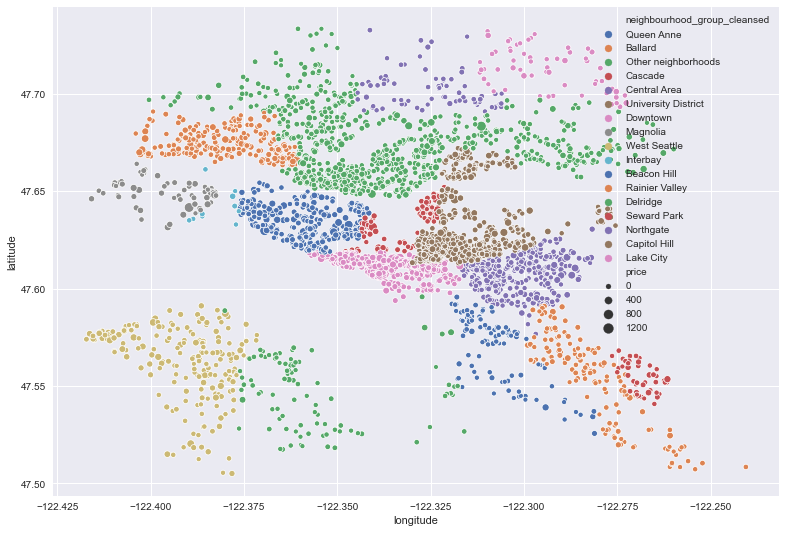

In [5]:
plt.figure(figsize=(13,9))
plt.style.use('seaborn')
sns.scatterplot(data = df, x="longitude", y="latitude", size = 'price',hue ='neighbourhood_group_cleansed', palette="deep")
plt.ioff()

* The figure above indicates how listing are spread across neighbourhood, the colors represent the neighborhoods and the marker sizes represent the price ranges. We can clearly differntiate the neighbourhoods but hard to see the price information. However 

* it is difficult to see and interprete price distribution accross neighbourhood.

* To get a clearly picture of price distribution accross neighbourhood, we plot distibution of the median price across each neighbourhood

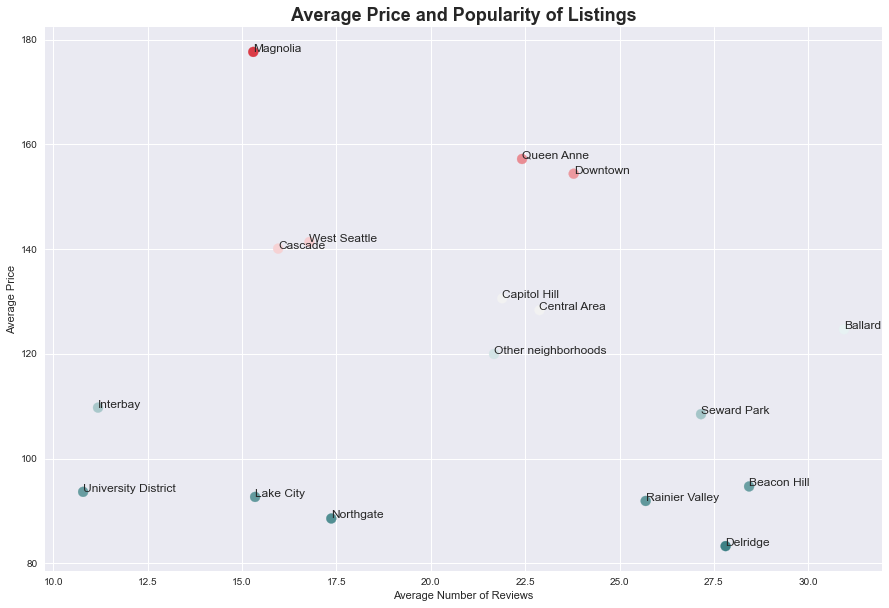

In [6]:
def plot_price_vs_popularity(df, top_k):
    x = df.groupby('neighbourhood_group_cleansed')[
        'number_of_reviews'].mean().sort_index()[:top_k]
    y = df.groupby('neighbourhood_group_cleansed')[
        'price'].mean().sort_index()[:top_k]
    n = (x.reset_index()).neighbourhood_group_cleansed.tolist()[:top_k]
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(x, y, c=y, cmap=sns.diverging_palette(
        200, 10, sep=20, as_cmap=True), s=100)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]), fontsize=12)

    plt.xlabel('Average Number of Reviews')
    plt.ylabel('Average Price')
    plt.title('Average Price and Popularity of Listings',
              fontsize=18, fontweight='bold')
plot_price_vs_popularity(df, 30)

* Clearly Charlottenburg-Wilm and Tempelhof - Schöneberg are the most expensive neighbourhood with average price of  120 and 100 dollas respectively. Followed by Mitte and Pankow with the rest in the range between 45 and 70 dollas

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text major ticklabel objects>)

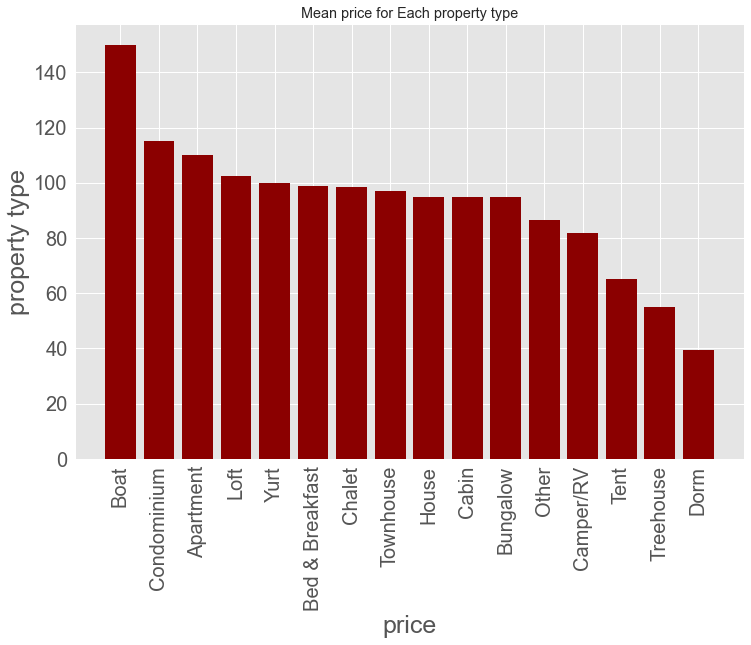

In [7]:
mean_property_price = df.groupby('property_type')['price'].median().sort_values(ascending =False).reset_index()
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,8)
plt.title('Mean price for Each property type')
plt.bar(mean_property_price['property_type'],mean_property_price['price'],color ='darkred' )
plt.xlabel('price',fontsize=25)
plt.ylabel('property type',fontsize=25)
plt.tick_params(labelsize=20)
plt.xticks(rotation= 'vertical')

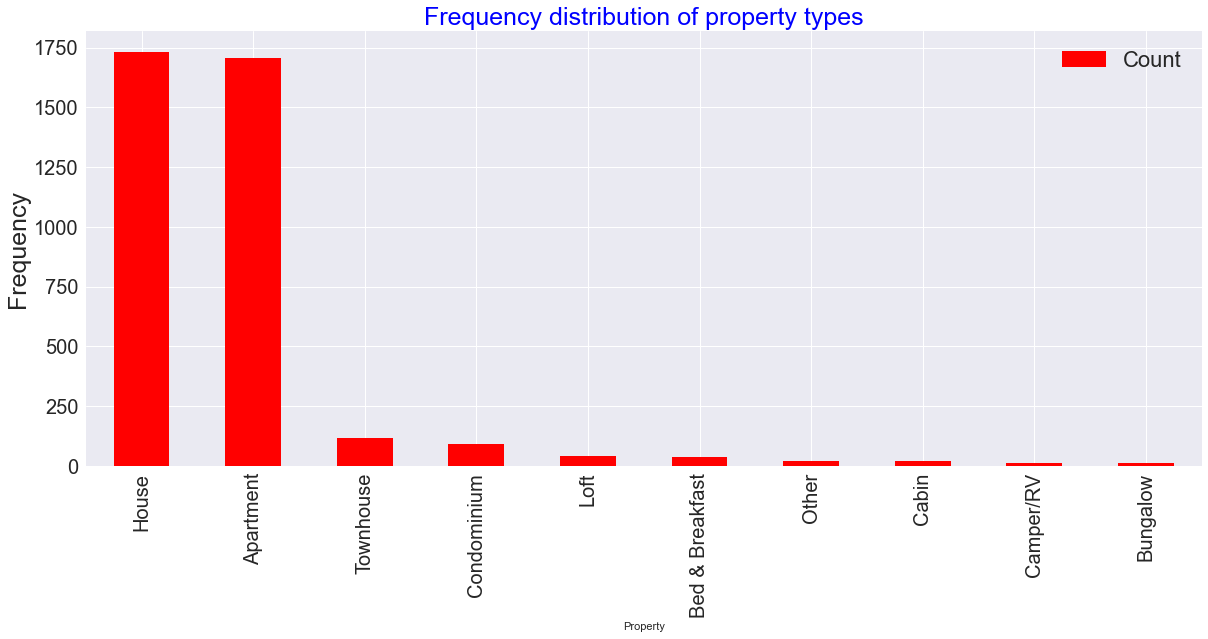

In [8]:
def property_distribution(df,title):
    all_properties=df['property_type'].tolist()
    fdist = FreqDist(all_properties)
    prop = pd.DataFrame({'Property': list(fdist.keys()),'Count': list(fdist.values())})
    prop = prop.nlargest(columns="Count", n = 10)
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize']=(20,8)
    prop.plot(x='Property',y='Count',kind='bar',color='red')
    plt.ylabel('Frequency',fontsize=25)
    plt.title(title,fontsize=25,color='blue')
    plt.tick_params(labelsize=20)
    plt.xticks(rotation='vertical')
    plt.legend(fontsize=22)
    plt.show()

title='Frequency distribution of property types'
property_distribution(df,title)



Text(0.5, 1.0, 'Price Vs room type')

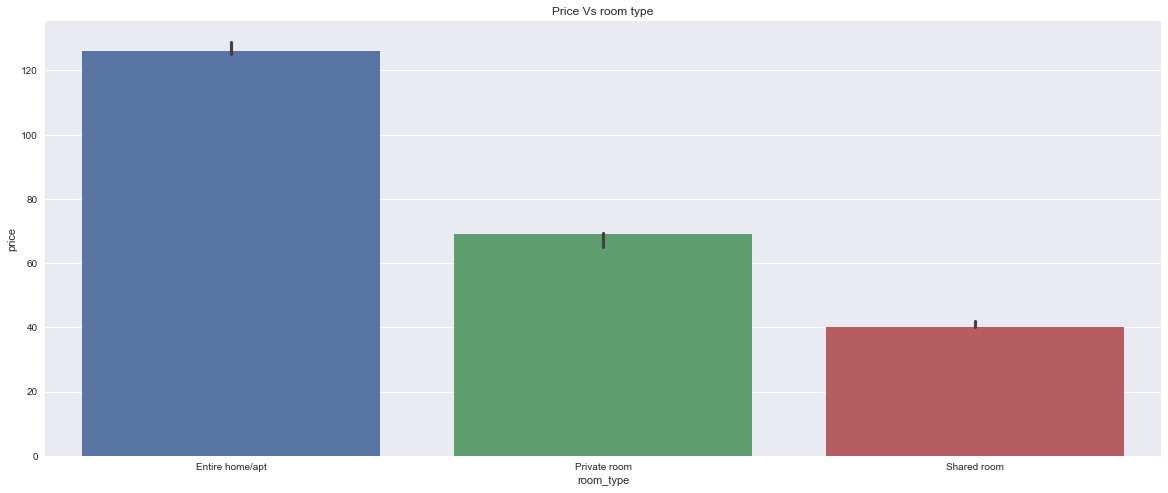

In [9]:
sns.barplot(x="room_type", y="price", data=df, estimator=median).set_title("Price Vs room type")